In [1]:
import numpy as np
import pandas as pd
import yaml 

import datetime
import math
from scipy.interpolate import interp1d
import subprocess

import glob
import os
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Util.util as util
#from astroObjectAnalyser.DataAnalysis.analysis import Analysis
from astroObjectAnalyser.astro_object_superclass import StrongLensSystem
import h5py

from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable


from astropy.visualization import simple_norm
import shutil

In [2]:
def psf_maker(z4, object_name,band,camera):
    cutout_dir = os.path.join(Main_dir, 'cutout/{}/'.format(object_name,band,camera)) 

    f = open('psf_templates/psf_{}_{}.par'.format(band,camera),'r')
    filedata = f.read()
    f.close()    
    
    
    # despace correction
    
    f = open('psf_templates/psf_{}_{}.par'.format(band,camera),'r')
    filedata = f.read()
    f.close()    
    
    
    if camera == "ACS":
        newdata = filedata.replace("0.028000 # Z4 = Focus for center of ACS/WFC field",
                                   "  {0:.3f}    # Z4 = Focus for center of ACS/WFC field".format(0.028 + z4))
    elif camera == "WFPC2":
        newdata = filedata.replace("-0.117000 # Z4 = Focus for center of chip",
                                   "  {0:.3f}    # Z4 = Focus for center of chip".format(-0.117 + z4))
        
    elif camera == "WFC3" and band != "F160w":
        newdata = filedata.replace("0.000000 # Z4 = Focus",
                                   "  {0:.3f}    # Z4 = Focus".format(0.00 + z4))      
        
    elif camera == "WFC3" and band == "F160w":
        newdata = filedata.replace("0.000000 # Z4 = Focus",
                                   "  {0:.3f}    # Z4 = Focus".format(0.00 + z4))
    f = open('psf_{}_{}_date.par'.format(band,camera),'w')
    f.write(newdata)
    f.close()  



    subprocess.run(["export /usr/local/mybin/tinytim"],  capture_output=True, shell=True,  )
    subprocess.run(["~/mybin/tinytim/tiny2  psf_{}_{}_date.par".format(band,camera)],
                   capture_output=True, shell=True  )   
    
    if camera == "WFPC2":
        hdu = fits.open('psf_{}_{}00.fits'.format(band,camera))
    else:
        hdu = fits.open('psf_{}_{}00_psf.fits'.format(band,camera))
    fitssize=hdu[0].shape[0]
    #print(fitssize)
    
    psf = hdu[0].data[int(fitssize/2)-30:int(fitssize/2)+31,int(fitssize/2)-30:int(fitssize/2)+31]


   # print(psf.shape)
    plt.imshow(np.log10(psf), cmap='cubehelix') 
    plt.show()


    psf_filename = 'psf_{}_{}.h5'.format(object_name, band)
    f = h5py.File(psf_filename, "w")
    dset = f.create_dataset('kernel_point_source', data=psf)
    
    
    f.close()

    # Remove all the files in the notebook directory with the following suffixes.
    files_to_clean = ['par','fits','tt3']

    for suffix in files_to_clean:
        filelist = glob.glob("./*.{}".format(suffix))

        for file in filelist:
            os.remove(file)    

    # move raw data files to temporary directory to work on
    for file in glob.glob( "*.h5"):
        shutil.copy2(file, cutout_dir)
        
    filelist = glob.glob("./*.h5")
    for file in filelist:
        os.remove(file) 
    return psf

In [5]:


ACS_UV_PixelSize  = 0.05
WFC3_UV_PixelSize  = 0.04
ACS_bands = ['F555W','F814W']
WFC3_bands = ['F390W']

In [6]:
for b in ACS_bands:
    f = open('psf_templates/psf_{}_{}.par'.format(b,"ACS"),'r')
    filedata = f.read()
    f.close()
    k = (filedata.find('# Integrated PSF scaling (arcsec)'))
    assert (float(filedata[int(k-10):int(k-2)])) == ACS_UV_PixelSize

for b in WFC3_bands:
    f = open('psf_templates/psf_{}_{}.par'.format(b,"WFC3"),'r')
    filedata = f.read()
    f.close()
    k = (filedata.find('# Integrated PSF scaling (arcsec)'))
    assert (float(filedata[int(k-10):int(k-2)])) == WFC3_UV_PixelSize


print("PSF has correct pixel sizes")

PSF has correct pixel sizes


In [7]:
camera_offset = {"WFPC2":0.23,
                 "ACS"  :0.09,
                 "WFC3" :-0.34}
    

In [8]:
df = pd.read_csv("psf_templates/Hubble_dspace.csv")


In [9]:
dspace_finder = interp1d(df['date'], df['focus'])



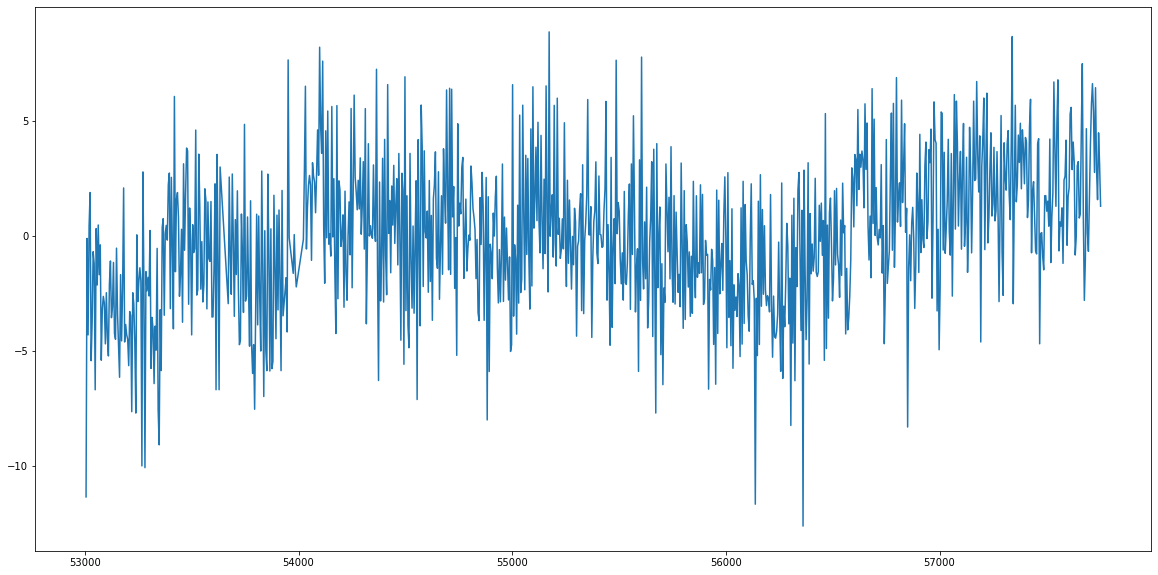

In [10]:
x = np.linspace(float(np.min(df['date'])),float(max(df['date'])),1000)
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(x,dspace_finder(x))
plt.show()

In [11]:
def PSF_Wrapper(object_name,band,camera,HST_date):
    times = '{}-{}-{}T{}'.format(HST_date[6:10],HST_date[3:5],HST_date[0:2],HST_date[11:])
    t = Time(times, format='isot', scale='utc')
    dspace=dspace_finder(t.mjd) + camera_offset[camera]
    z4=(dspace*0.011)
    psf_maker(z4,object_name,band,camera)
    


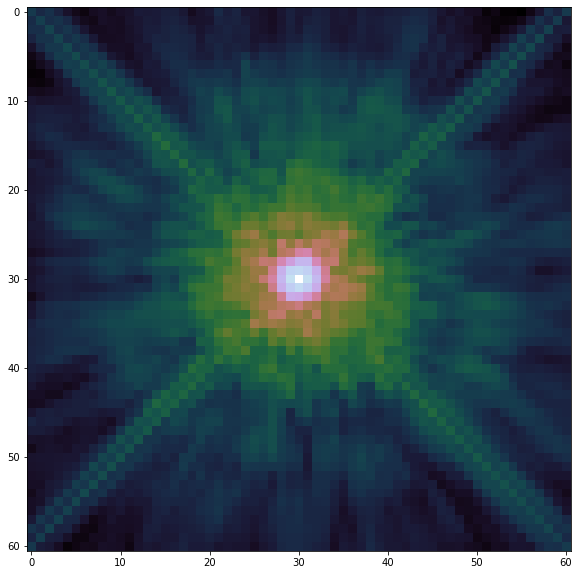

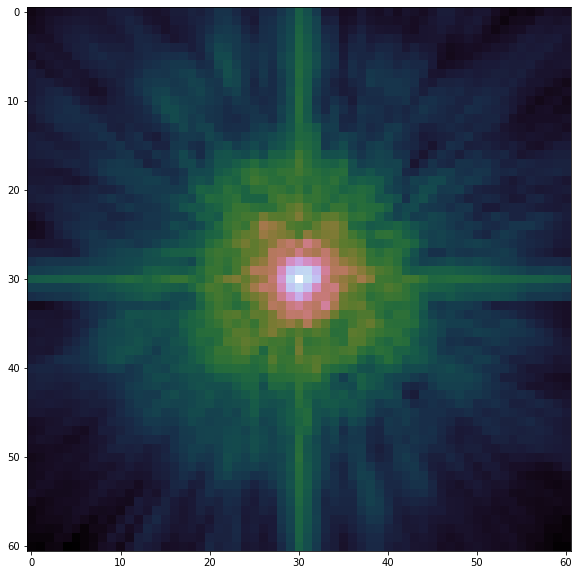

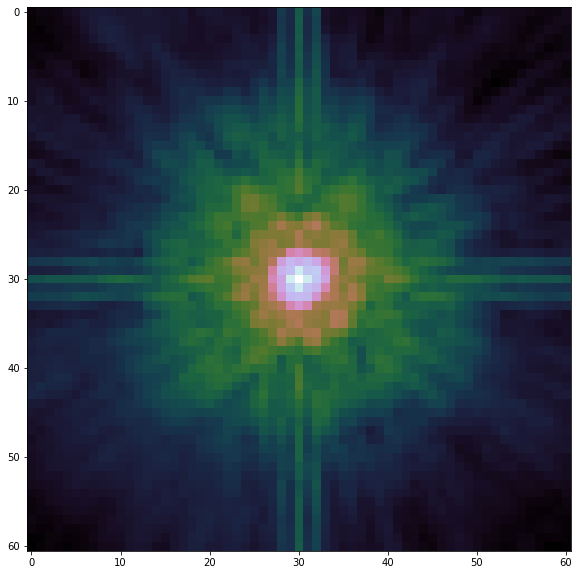

In [12]:
Main_dir = '../lenses/'


PSF_Wrapper('SDSSJ1627-0053','F390W','WFC3', '16/06/2013 15:08')
PSF_Wrapper('SDSSJ1627-0053','F555W','ACS' , '12/03/2006 09:29') #DD/MM/YYYY
PSF_Wrapper('SDSSJ1627-0053','F814W','ACS' , '12/03/2006 12:47')
